# 1 Finding Co-located EMIT and NEON AOP Data

**Summary**  

The Earth surface Mineral dust source InvesTigation (EMIT) instrument is located on the International Space Station (ISS) and has collected data over a large area of the Continental US. The National Ecological Observatory Network (NEON) Airborne Observation Platform (AOP) collects aerial remote sensing data, including hyperspectral reflectance data over sites across the United States and Puerto Rico. In this notebook we will show how to utilize the [`earthaccess` Python library](https://github.com/nsidc/earthaccess) to find spatially overlapping EMIT and NEON reflectance data at NEON's [Soaproot Saddle](https://www.neonscience.org/field-sites/soap) site (SOAP) in California. In Sept 2020 and June 2021, the Creek Fire and Blue Fires burned a portions of the site, so data at this site would be interesting to investigate wildfire disturbance and recovery.

**Background**

The **EMIT** instrument is an imaging spectrometer that measures light in visible (V) to short-wave (SWIR) infrared wavelengths; this is also referred to as a VSWIR sensor. These measurements display unique spectral signatures that correspond to the composition on the Earth's surface. The EMIT mission focuses specifically on mapping the composition of minerals to better understand the effects of mineral dust throughout the Earth system and human populations now and in the future. In addition, the EMIT instrument can be used in other applications, such as mapping of greenhouse gases, snow properties, and water resources.

More details about EMIT and its associated products can be found on the [EMIT website](https://earth.jpl.nasa.gov/emit/) and [EMIT product pages](https://lpdaac.usgs.gov/product_search/?query=EMIT&status=Operational&view=cards&sort=title) hosted by the LP DAAC.

The **NEON Imaging Spectrometer (NIS)** is an airborne [imaging spectrometer](https://www.neonscience.org/data-collection/imaging-spectrometer) built by JPL (AVIRIS-NG) and operated by the National Ecological Observatory Network's (NEON) Airborne Observation Platform (AOP). NEON's hyperspectral sensors collect measurements of sunlight reflected from the Earth's surface in 426 narrow (~5 nm) spectral channels spanning wavelengths between ~ 380 - 2500 nm. NEON's remote sensing data is intended to map and answer questions about a landscape, with ecological applications including identifying and classifying plant species and communities, mapping vegetation health, detecting disease or invasive species, and mapping droughts, wildfires, or other natural disturbances and their impacts. 

NEON surveys sites spanning the continental US, during peak phenological greenness, capturing each site 3 out of every 5 years, for most terrestrial sites. AOP's [Flight Schedules and Coverage](https://www.neonscience.org/data-collection/flight-schedules-coverage) provide's more information about the current and past schedules.

More detailed information about NEON's airborne sampling design can be found in the paper: [Spanning scales: The airborne spatial and temporal sampling design of the National Ecological Observatory Network](https://besjournals.onlinelibrary.wiley.com/doi/10.1111/2041-210X.13942).

**Requirements**  
 - [NASA Earthdata Account](https://urs.earthdata.nasa.gov/home)   
 - *No Python setup requirements if connected to the workshop cloud instance!*  
 - **Local Only** Set up Python Environment - See **setup_instructions.md** in the `/setup/` folder to set up a local compatible Python environment

 - NEON API Token (optional, but recommended), see [NEON API Tokens Tutorial](https://www.neonscience.org/resources/learning-hub/tutorials/neon-api-tokens-tutorial)

**Download the NEON Flight Boundary Shapefile:** <a href="https://www.neonscience.org/sites/default/files/AOP_flightBoxes_0.zip" class="link--button link--arrow">AOP_flightBoxes.zip</a>

**Learning Objectives**  
- Use functions provided in an external Python module to find and download available NEON airborne reflectance data.
- Use `earthaccess` to find EMIT data that overlaps with a NEON site.
- How to export a list of files and download them programmatically.  

**Tutorial Outline**  

1. Setup
2. Explore NEON sites and finding available NEON reflectance data
3. Search for EMIT reflectance data  
4. Organize and filter results
5. Visualize intersecting NEON-EMIT coverage
6. Create a list of EMIT asset URLs
7. Download EMIT data

## 1. Setup

Import the required Python libraries.

In [1]:
# Import required libraries
import os, sys
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import math
import requests

from zipfile import ZipFile
from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt

### 1.2 NEON Data API and Python Functions

Note: In Sept-Oct 2024, these next two chunks of code can be replaced with the Python neonUtilities package, which has built in functions for downloading NEON AOP data.

In [2]:
# function to download data stored on the internet in a public url to a local file
def download_url(url,download_dir):
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
    filename = url.split('/')[-1]
    r = requests.get(url, allow_redirects=True)
    file_object = open(os.path.join(download_dir,filename),'wb')
    file_object.write(r.content)

In [3]:
neon_code_folder = './neon_python_modules'
aop_download_module_url = "https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/aop_python_modules/neon_aop_download_functions.py"
download_url(aop_download_module_url,neon_code_folder)
#os.listdir(neon_code_folder) #optionally show the contents of this directory to confirm the files downloaded

# add the code folder to the path and import the neon aop download functions module
sys.path.insert(0,neon_code_folder)
import neon_aop_download_functions as aop_dl;

### 1.3 NASA Earthdata Login Credentials

To download or stream NASA data you will need an Earthdata account, you can create one [here](https://urs.earthdata.nasa.gov/home). We will use the `login` function from the `earthaccess` library for authentication before downloading at the end of the notebook. This function can also be used to create a local `.netrc` file if it doesn't exist or add your login info to an existing `.netrc` file. If no Earthdata Login credentials are found in the `.netrc` you'll be prompted for them. This step is not necessary to conduct searches but is needed to download or stream data.

## 2. Search for NEON and EMIT Data

NEON data products are hosted on the NEON Data Portal, and can be accessed via an API. We will import a Python module including some functions that interact with the NEON data API to easily see what data are available (in what years), and download data.

The EMIT products are hosted by the Land Processes Distributed Active Archive Center (LP DAAC). In this example we will use the cloud-hosted EMIT_L2A_RFL and ECOSTRESS_L2T_LSTE products available from the LP DAAC to find data. Any results we find for these products, should be available for other products within the EMIT and ECOSTRESS collections. 

To find data we will use the [`earthaccess` Python library](https://github.com/nsidc/earthaccess). `earthaccess` searches NASA's Common Metadata Repository (CMR), a metadata system that catalogs Earth Science data and associated metadata records. The results can then be used to download granules or generate lists of granule search result URLs.

Using `earthaccess` we can search based on the attributes of a granule, which can be thought of as a spatiotemporal scene from an instrument containing multiple assets (ex: Reflectance, Reflectance Uncertainty, Masks for the EMIT L2A Reflectance Collection). We can search using attributes such as collection, acquisition time, and spatial footprint. This process can also be used with other EMIT or ECOSTRESS products, other collections, or different data providers, as well as across multiple catalogs with some modification. 

### 2.1 Define Spatial Regions of Interest (ROIs)

For this example, our spatial region of interest (ROI) will be the NEON site [SOAP)](https://www.neonscience.org/field-sites/soap) in the Sierra National Forest, California.

In this example, we will create a rectangular ROI surrounding the SOAP flight box. We will search for co-located EMIT data using a polygon rather than a standard bounding box in `earthaccess`. To search for intersections with a polygon using earthaccess, we need to format our ROI as a counterclockwise list of coordinate pairs. 

Download, Unzip, and Open the shape file (.shp) containing the AOP flight box boundaries, which can be downloaded from [NEON Spatial Data and Maps](https://www.neonscience.org/data-samples/data/spatial-data-maps). Read this into a `geodataframe`, explore the contents, and check the coordinate reference system (CRS) of the data.

In [4]:
# Download and Unzip the NEON Flight Boundary Shapefile
neon_boundary_url = "https://www.neonscience.org/sites/default/files/AOP_flightBoxes_0.zip"
# Use download_url function to save the file to a directory
os.makedirs('./data', exist_ok=True)
download_url(neon_boundary_url,'./data')
# Unzip the file
with ZipFile(f"./data/{neon_boundary_url.split('/')[-1]}", 'r') as zip_ref:
    zip_ref.extractall('./data')

In [5]:
aop_flightboxes = gpd.read_file("./data/AOP_flightBoxes/AOP_flightboxesAllSites.shp")
aop_flightboxes.head()

domain domainName                                 siteName siteID  siteType  \
0    D01  Northeast        Bartlett Experimental Forest NEON   BART  Gradient   
1    D01  Northeast  Harvard Forest & Quabbin Watershed NEON   HARV      Core   
2    D01  Northeast  Harvard Forest & Quabbin Watershed NEON   HARV      Core   
3    D01  Northeast                     Lower Hop Brook NEON   HOPB      Core   
4    D19      Taiga                               Healy NEON   HEAL  Gradient   

    sampleType  priority  version         flightbxID  \
0  Terrestrial         1        1  D01_BART_R1_P1_v1   
1  Terrestrial         1        1  D01_HARV_C1_P1_v1   
2  Terrestrial         3        1  D01_HARV_C1_P3_v1   
3      Aquatic         2        1  D01_HOPB_C1_P2_v1   
4  Terrestrial         1        1  D19_HEAL_R3_P1_v1   

                                            geometry  
0  POLYGON ((-71.33426 43.99197, -71.33423 44.081...  
1  POLYGON ((-72.14819 42.5751, -72.14776 42.3837...  
2  POLYGON ((-72.10812 42.43653, -72.14788 42.436...  
3  POLYGON ((-72.36635 42.46399, -72.36635 42.514...  
4  POLYGON ((-149.31505 63.82981, -149.31505 63.9...

In [6]:
aop_flightboxes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The CRS is **EPSG:4326** (WGS84), which is also the CRS we want the data in to submit for our search of EMIT data.

Next, let's examine the AOP flightboxes polygons further.

In [7]:
site_id = 'SOAP'
aop_flightboxes[aop_flightboxes.siteID == site_id]

domain         domainName              siteName siteID  siteType  \
89    D17  Pacific Southwest  Soaproot Saddle NEON   SOAP  Gradient   
90    D17  Pacific Southwest  Soaproot Saddle NEON   SOAP  Gradient   
91    D17  Pacific Southwest  Soaproot Saddle NEON   SOAP  Gradient   

     sampleType  priority  version         flightbxID  \
89  Terrestrial         1        6  D17_SOAP_R1_P1_v6   
90  Terrestrial         2        2  D17_SOAP_R1_P2_v2   
91  Terrestrial         3        1  D17_SOAP_R1_P3_v1   

                                             geometry  
89  POLYGON ((-119.29195 37.0143, -119.29192 37.10...  
90  POLYGON ((-119.32506 37.01417, -119.32506 37.0...  
91  POLYGON ((-119.31839 36.98832, -119.31839 37.0...

We can see the site `geodataframe` consists of a single polygon, that we want to include in our study site (sometimes NEON sites may have more than one polygon, as there are sometimes multiple areas, with different priorities for collection).

In [8]:
# write this to a new variable called "site_polygon"
site_polygon = aop_flightboxes[aop_flightboxes.siteID == site_id]
# subset to only include columns of interest
site_polygon = site_polygon[['domain','siteName','siteID','sampleType','flightbxID','priority','geometry']]

In [9]:
# Create external boundary of the shape
site_roi_poly = site_polygon.unary_union.envelope
# Re-order vertices to counterclockwise
site_roi_poly = orient(site_roi_poly, sign=1.0)

C:\Users\riede\AppData\Local\Temp\ipykernel_7948\2142134814.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  site_roi_poly = site_polygon.unary_union.envelope


Make a `GeoDataFrame` consisting of the bounding box geometry.

In [10]:
site_df = pd.DataFrame({"Name":["SOAP ROI Bounding Box"]})
site_bbox = gpd.GeoDataFrame({"Name":["SOAP ROI Bounding Box"], "geometry":[site_roi_poly]},crs="EPSG:4326")
site_bbox

Name                                           geometry
0  SOAP ROI Bounding Box  POLYGON ((-119.32506 36.98826, -119.17673 36.9...

We can write this bounding box to a `geojson` file for use in future notebooks. This is commented out for now, but you can uncomment and run the cell below, if desired.

Next we can visualize our region of interest and the exterior boundary polygon containing ROIs. First add a function to help reformat bounding box coordinates to work with leaflet notation.

In [11]:
# Function to convert a bounding box for use in leaflet notation
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [12]:
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add Site Bounding Box
folium.GeoJson(site_bbox, name='bounding_box').add_to(map1)

# Add site roi geodataframe
site_polygon.explore("flightbxID",
                     popup=True,
                     categorical=True,
                     cmap='Set3',
                     style_kwds=dict(opacity=0.7, fillOpacity=0.4),
                     name="SOAP ROI",
                     m=map1)

map1.add_child(folium.LayerControl())
map1.fit_bounds(bounds=convert_bounds(site_polygon.unary_union.bounds))
display(fig)

C:\Users\riede\AppData\Local\Temp\ipykernel_7948\3472794785.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map1.fit_bounds(bounds=convert_bounds(site_polygon.unary_union.bounds))


Above we can see the SOAP flightbox, and the exterior boundary polygon containing the full area.

Lastly, we need to convert our polygon to a list of coordinate pairs, to create our Region of Interest (ROI).

In [13]:
# Set ROI as list of exterior polygon vertices as coordinate pairs
site_roi = list(site_roi_poly.exterior.coords)
site_roi

[(-119.3250598477851, 36.98825625902822),
 (-119.17673167047963, 36.98825625902822),
 (-119.17673167047963, 37.1042875313546),
 (-119.3250598477851, 37.1042875313546),
 (-119.3250598477851, 36.98825625902822)]

Finally we can look at the available NEON hyperspectral reflectance data over the site. NEON hyperspectral reflectance data are currently available under two different revisions, as AOP is in the process of implementing a BRDF (Bidirectional Reflectance Distribution Function), but this has not been applied to the full archive of data yet. These data are available under two revisions of the data product ID DP3.30006 - DP3.30006.001 are the directional surface reflectance, and DP3.30006.002 are the bidirectional (BRDF- and topographic- corrected) surface reflectance. Let's see what's available for each of these data products.

In [14]:
refl_rev1_dpid = 'DP3.30006.001'
refl_rev2_dpid = 'DP3.30006.002'
site = site_id

In [15]:
print(f'Directional Reflectance Data Available at NEON Site {site_id}')
aop_dl.list_available_urls(refl_rev1_dpid,site)

Directional Reflectance Data Available at NEON Site SOAP


['https://data.neonscience.org/api/v0/data/DP3.30006.001/SOAP/2013-06',
 'https://data.neonscience.org/api/v0/data/DP3.30006.001/SOAP/2017-07',
 'https://data.neonscience.org/api/v0/data/DP3.30006.001/SOAP/2018-06',
 'https://data.neonscience.org/api/v0/data/DP3.30006.001/SOAP/2019-06',
 'https://data.neonscience.org/api/v0/data/DP3.30006.001/SOAP/2021-07']

In [16]:
print(f'Bidirectional Reflectance Data Available at NEON Site {site_id}')
aop_dl.list_available_urls(refl_rev2_dpid,site)

Bidirectional Reflectance Data Available at NEON Site SOAP


['https://data.neonscience.org/api/v0/data/DP3.30006.002/SOAP/2023-06',
 'https://data.neonscience.org/api/v0/data/DP3.30006.002/SOAP/2023-07',
 'https://data.neonscience.org/api/v0/data/DP3.30006.002/SOAP/2024-06']

The bidirectional data for the 2nd 2023 and 2024 visits of SOAP may have some overlap with EMIT data. Let's start with 2024 AOP data.

In [17]:
year = '2024'

We can download the reflectance data using the function `aop_dl.download_aop_files`. You can change the download path if desired.

Before we download the data, let's look at the spatial extent. AOP data are provided in UTM projection. We can do this by downloading shapefiles of the tile boundaries. These are available as metadata provided along with the reflectance data products. The full boundary of the site is a file called "merged_tiles.shp/.shx". Let's only download this shapefile so we can see the file extent, and determine the UTM coordinates of the tiles we wish to download.

In [18]:
aop_dl.download_aop_files?

Signature:
aop_dl.download_aop_files(
    product,
    site,
    year=None,
    download_folder='./data',
    match_string=None,
    check_size=True,
)
Docstring:
download_aop_files downloads NEON AOP files from the AOP for a given data product, site, and 
optional year, download folder, and 
--------
 Inputs:
     required:
         product: the data product code (eg. 'DP3.30015.001' - CHM)
         site: the 4-digit NEON site code (eg. 'SRER', 'JORN')
     
     optional:
         year: year (eg. '2020'); default (None) is all years
         download_folder: folder to store downloaded files; default (./data) in current directory
         match_string: subset of data to match, need to use exact pattern for file name
         check_size: prompt to continue download (y/n) after displaying size; default = True
--------
Usage:
--------
download_aop_files('DP3.30015.001','JORN','2019','./data/JORN_2019/CHM','314000_3610000_CHM.tif')
File:      c:\users\riede\documents\eda capstone\aop-emit

In [20]:
# download the full-boundary shape files from the lidar data.
# These are delivered as metadata as part of one of the Lidar data products, so note that the data product id (DPID) is different
aop_dl.download_aop_files('DP1.30003.001',site,year,'./data/neon_refl',match_string='.shp',check_size=False)
aop_dl.download_aop_files('DP1.30003.001',site,year,'./data/neon_refl',match_string='.shx',check_size=False)

Download size: 0.35 kB
downloading NEON_D17_SOAP_DPQA_2024_full_boundary_all_files.shp to ./data/neon_refl
Download size: 0.01 kB
downloading NEON_D17_SOAP_DPQA_2024_full_boundary_all_files.shx to ./data/neon_refl


The reflectance data can be large in size, so for now, we'll just download a single tile, in the center of the site. We can do that with the `download_aop_files` function as follows. This time leave out the `check_size` input parameter, and that will default to True. This will prompt you to download after displaying the download size. This reflectance file is ~615 MB, so make sure you have enough space on your local disk before downloading.

In [21]:
# download a reflectance hdf5 tile
aop_dl.download_aop_files('DP3.30006.002',site,year,'./data/neon_refl',match_string='568000_4901000_reflectance.h5')

Download size: 0 bytes


Do you want to continue with the download? (y/n)  y


### 2.2 Define EMIT Collections of Interest
We need to specify which products we want to search for. The best way to do this is using their concept-id. As mentioned above, we will conduct our search using the EMIT Level 2A Reflectance (EMITL2ARFL). We can do some quick collection queries using `earthaccess` to retrieve the concept-id for each dataset. 

In [22]:
# EMIT Collection Query
emit_collection_query = earthaccess.collection_query().keyword('EMIT L2B Reflectance')
emit_collection_query.fields(['ShortName','EntryTitle','Version']).get()

[{
   "meta": {
     "concept-id": "C2408750690-LPCLOUD",
     "granule-count": 148252,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "EMITL2ARFL",
     "EntryTitle": "EMIT L2A Estimated Surface Reflectance and Uncertainty and Masks 60 m V001",
     "Version": "001"
   }
 }]

If your search returns multiple products, be sure to select the right concept-id For this example it will be the first one. Create a list of these concept-ids for our data search.

In [23]:
# Data Collections for our search
emit_concept_id = ['C2408750690-LPCLOUD']

### 2.3 Define Date Range

For our date range, we'll look at data collected between January 2022 and October 2023. The `date_range` can be specified as a pair of dates, start and end (up to, not including).

In [24]:
# Define Date Range
date_range = ('2022-01-01','2024-11-01')

### 2.4 Searching

Submit a query using `earthaccess`, usin the `site_roi` as the region of interest.

In [25]:
emit_query_results = earthaccess.search_data(
    concept_id=emit_concept_id,
    polygon=site_roi,
    temporal=date_range,
    count=500)


## 3. Organizing and Filtering Results

As we can see from above, the results object contains a list of objects with metadata and links. We can convert this to a more readable format, a dataframe. In addition, we can make it a geodataframe by taking the spatial metadata and creating a shapely polygon representing the spatial coverage, and further customize which information we want to use from other metadata fields.

First, we define some functions to help us create a shapely object for our geodataframe, and retrieve the specific browse image URLs that we want. By default, the browse image selected by `earthaccess` is the first one in the list, but the ECO_L2_LSTE has several browse images, and we want to make sure we retrieve the `png` file, which is a preview of the LSTE.

In [26]:
# Function to create shapely polygon of spatial coverage
def get_shapely_object(result:earthaccess.results.DataGranule):
    # Get Geometry Keys
    geo = result['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']
    keys = geo.keys()

    if 'BoundingRectangles' in keys:
        bounding_rectangle = geo['BoundingRectangles'][0]
        # Create bbox tuple
        bbox_coords = (bounding_rectangle['WestBoundingCoordinate'],bounding_rectangle['SouthBoundingCoordinate'],
                    bounding_rectangle['EastBoundingCoordinate'],bounding_rectangle['NorthBoundingCoordinate'])
        # Create shapely geometry from bbox
        shape = geometry.box(*bbox_coords, ccw=True)
    elif 'GPolygons' in keys:
        points = geo['GPolygons'][0]['Boundary']['Points']
        # Create shapely geometry from polygons
        shape = geometry.Polygon([[p['Longitude'],p['Latitude']] for p in points])
    else:
         raise ValueError('Provided result does not contain bounding boxes/polygons or is incompatible.')
    return(shape)

# Retrieve png browse image if it exists or first jpg in list of urls
def get_png(result:earthaccess.results.DataGranule):
    https_links = [link for link in result.dataviz_links() if 'https' in link]
    if len(https_links) == 1:
        browse = https_links[0]
    elif len(https_links) == 0:
        browse = 'no browse image'
        warnings.warn(f"There is no browse imagery for {result['umm']['GranuleUR']}.")
    else:
        browse = [png for png in https_links if '.png' in png][0]
    return(browse)

Now that we have our functions we can create a dataframe, then calculate and add our shapely geometries to make a geodataframe. After that, add a column for our browse image urls and print the number of granules in our results, so we can monitor the quantity we  are working with a we winnow down to the data we want.

In [27]:
# Create Dataframe of Results Metadata
emit_results_df = pd.json_normalize(emit_query_results)
# Create shapely polygons for result
geometries = [get_shapely_object(emit_query_results[index]) for index in emit_results_df.index.to_list()]
# Convert to GeoDataframe
emit_gdf = gpd.GeoDataFrame(emit_results_df, geometry=geometries, crs="EPSG:4326")
# Remove emit_results_df, no longer needed
del emit_results_df
# Add browse imagery links
emit_gdf['browse'] = [get_png(granule) for granule in emit_query_results]
emit_gdf['shortname'] = [result['umm']['CollectionReference']['ShortName'] for result in emit_query_results]
# Preview GeoDataframe
print(f'{emit_gdf.shape[0]} granules total')

23 granules total


Optionally preview the geodataframe to get an idea what it looks like.

In [28]:
emit_gdf.head()

size meta.concept-type      meta.concept-id  meta.revision-id  \
0  3580.819517           granule  G2597030211-LPCLOUD                 2   
1  3576.884192           granule  G2597513939-LPCLOUD                 2   
2  3580.734208           granule  G2658516156-LPCLOUD                 2   
3  3582.072193           granule  G2658516087-LPCLOUD                 2   
4  3579.419643           granule  G2738554768-LPCLOUD                 2   

                                 meta.native-id meta.collection-concept-id  \
0  EMIT_L2A_RFL_001_20220813T232430_2222515_007        C2408750690-LPCLOUD   
1  EMIT_L2A_RFL_001_20220817T214650_2222914_007        C2408750690-LPCLOUD   
2  EMIT_L2A_RFL_001_20230415T222408_2310515_006        C2408750690-LPCLOUD   
3  EMIT_L2A_RFL_001_20230415T222420_2310515_007        C2408750690-LPCLOUD   
4  EMIT_L2A_RFL_001_20230608T175820_2315912_004        C2408750690-LPCLOUD   

  meta.provider-id                        meta.format  \
0          LPCLOUD  application/vnd.nasa.cmr.umm+json   
1          LPCLOUD  application/vnd.nasa.cmr.umm+json   
2          LPCLOUD  application/vnd.nasa.cmr.umm+json   
3          LPCLOUD  application/vnd.nasa.cmr.umm+json   
4          LPCLOUD  application/vnd.nasa.cmr.umm+json   

         meta.revision-date  \
0  2024-10-24T14:18:58.975Z   
1  2024-10-24T14:49:05.713Z   
2  2024-10-25T01:54:51.232Z   
3  2024-10-25T01:54:52.927Z   
4  2024-10-25T09:40:08.679Z   

  umm.TemporalExtent.RangeDateTime.BeginningDateTime  ...  \
0                               2022-08-13T23:24:30Z  ...   
1                               2022-08-17T21:46:50Z  ...   
2                               2023-04-15T22:24:08Z  ...   
3                               2023-04-15T22:24:20Z  ...   
4                               2023-06-08T17:58:20Z  ...   

  umm.DataGranule.DayNightFlag  \
0                          Day   
1                          Day   
2                          Day   
3                          Day   
4                          Day   

   umm.DataGranule.ArchiveAndDistributionInformation  \
0  [{'Name': 'EMIT_L2A_RFL_001_20220813T232430_22...   
1  [{'Name': 'EMIT_L2A_RFL_001_20220817T214650_22...   
2  [{'Name': 'EMIT_L2A_RFL_001_20230415T222408_23...   
3  [{'Name': 'EMIT_L2A_RFL_001_20230415T222420_23...   
4  [{'Name': 'EMIT_L2A_RFL_001_20230608T175820_23...   

  umm.DataGranule.ProductionDateTime  \
0               2023-01-27T00:46:13Z   
1               2023-01-27T14:33:31Z   
2               2023-04-17T19:26:26Z   
3               2023-04-17T19:26:26Z   
4               2023-07-25T21:26:02Z   

                                       umm.Platforms  \
0  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
1  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
2  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
3  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
4  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   

                       umm.MetadataSpecification.URL  \
0  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
1  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
2  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
3  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
4  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   

  umm.MetadataSpecification.Name umm.MetadataSpecification.Version  \
0                          UMM-G                             1.6.6   
1                          UMM-G                             1.6.6   
2                          UMM-G                             1.6.6   
3                          UMM-G                             1.6.6   
4                          UMM-G                             1.6.6   

                                            geometry  \
0  POLYGON ((-119.46864 37.47018, -119.92542 36.8...   
1  POLYGON ((-119.68089 38.26041, -120.12322 37.6...   
2  POLYGON ((-119.72453 37.86227, -120.18778 37.2...   
3  POLYGON ((-119.0284 37.37526, -119.49146 36.72...   
4  POLYGON ((-119.63505 37.57834, -

There are a lot of columns with data that is not relevant for this exercise, so we can drop those. To do that, list the names of columns.

In [29]:
# List Column Names
emit_gdf.columns

Index(['size', 'meta.concept-type', 'meta.concept-id', 'meta.revision-id',
       'meta.native-id', 'meta.collection-concept-id', 'meta.provider-id',
       'meta.format', 'meta.revision-date',
       'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
       'umm.TemporalExtent.RangeDateTime.EndingDateTime', 'umm.GranuleUR',
       'umm.AdditionalAttributes',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.GPolygons',
       'umm.ProviderDates', 'umm.CollectionReference.ShortName',
       'umm.CollectionReference.Version', 'umm.PGEVersionClass.PGEName',
       'umm.PGEVersionClass.PGEVersion', 'umm.RelatedUrls', 'umm.CloudCover',
       'umm.DataGranule.DayNightFlag',
       'umm.DataGranule.ArchiveAndDistributionInformation',
       'umm.DataGranule.ProductionDateTime', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecification.Version', 'geometry', 'browse', 'shortname'],
      dtype='object')

Now create a list of columns to keep and use it to filter the dataframe.

In [30]:
# Create a list of columns to keep
keep_cols = ['meta.concept-id','meta.native-id', 'umm.TemporalExtent.RangeDateTime.BeginningDateTime','umm.TemporalExtent.RangeDateTime.EndingDateTime','umm.CloudCover','umm.DataGranule.DayNightFlag','geometry','browse', 'shortname']
# Remove unneeded columns
emit_gdf = emit_gdf[emit_gdf.columns.intersection(keep_cols)]
emit_gdf.head()

meta.concept-id                                meta.native-id  \
0  G2597030211-LPCLOUD  EMIT_L2A_RFL_001_20220813T232430_2222515_007   
1  G2597513939-LPCLOUD  EMIT_L2A_RFL_001_20220817T214650_2222914_007   
2  G2658516156-LPCLOUD  EMIT_L2A_RFL_001_20230415T222408_2310515_006   
3  G2658516087-LPCLOUD  EMIT_L2A_RFL_001_20230415T222420_2310515_007   
4  G2738554768-LPCLOUD  EMIT_L2A_RFL_001_20230608T175820_2315912_004   

  umm.TemporalExtent.RangeDateTime.BeginningDateTime  \
0                               2022-08-13T23:24:30Z   
1                               2022-08-17T21:46:50Z   
2                               2023-04-15T22:24:08Z   
3                               2023-04-15T22:24:20Z   
4                               2023-06-08T17:58:20Z   

  umm.TemporalExtent.RangeDateTime.EndingDateTime  umm.CloudCover  \
0                            2022-08-13T23:24:42Z               9   
1                            2022-08-17T21:47:02Z              93   
2                            2023-04-15T22:24:20Z              23   
3                            2023-04-15T22:24:32Z              27   
4                            2023-06-08T17:58:32Z              47   

  umm.DataGranule.DayNightFlag  \
0                          Day   
1                          Day   
2                          Day   
3                          Day   
4                          Day   

                                            geometry  \
0  POLYGON ((-119.46864 37.47018, -119.92542 36.8...   
1  POLYGON ((-119.68089 38.26041, -120.12322 37.6...   
2  POLYGON ((-119.72453 37.86227, -120.18778 37.2...   
3  POLYGON ((-119.0284 37.37526, -119.49146 36.72...   
4  POLYGON ((-119.63505 37.57834, -120.4885 36.97...   

                                              browse   shortname  
0  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
1  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
2  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
3  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
4  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL

This is looking better, but we can make it more readable by renaming our columns.

In [31]:
# Rename some Columns
emit_gdf.rename(columns = {'meta.concept-id':'concept_id','meta.native-id':'granule',
                           'umm.TemporalExtent.RangeDateTime.BeginningDateTime':'start_datetime',
                           'umm.TemporalExtent.RangeDateTime.EndingDateTime':'end_datetime',
                           'umm.CloudCover':'cloud_cover',
                           'umm.DataGranule.DayNightFlag':'day_night'}, inplace=True)
emit_gdf

concept_id                                       granule  \
0   G2597030211-LPCLOUD  EMIT_L2A_RFL_001_20220813T232430_2222515_007   
1   G2597513939-LPCLOUD  EMIT_L2A_RFL_001_20220817T214650_2222914_007   
2   G2658516156-LPCLOUD  EMIT_L2A_RFL_001_20230415T222408_2310515_006   
3   G2658516087-LPCLOUD  EMIT_L2A_RFL_001_20230415T222420_2310515_007   
4   G2738554768-LPCLOUD  EMIT_L2A_RFL_001_20230608T175820_2315912_004   
5   G2738554498-LPCLOUD  EMIT_L2A_RFL_001_20230608T175832_2315912_005   
6   G2736728172-LPCLOUD  EMIT_L2A_RFL_001_20230622T193237_2317313_006   
7   G2737583843-LPCLOUD  EMIT_L2A_RFL_001_20230626T175417_2317712_006   
8   G2737583846-LPCLOUD  EMIT_L2A_RFL_001_20230626T175429_2317712_007   
9   G2743397410-LPCLOUD  EMIT_L2A_RFL_001_20230731T205320_2321214_004   
10  G2759644643-LPCLOUD  EMIT_L2A_RFL_001_20230826T175001_2323812_003   
11  G2759650982-LPCLOUD  EMIT_L2A_RFL_001_20230826T175013_2323812_004   
12  G2812241728-LPCLOUD  EMIT_L2A_RFL_001_20231201T201035_2333513_004   
13  G2846588026-LPCLOUD  EMIT_L2A_RFL_001_20240127T213352_2402714_005   
14  G2846589029-LPCLOUD  EMIT_L2A_RFL_001_20240127T213403_2402714_006   
15  G2871103914-LPCLOUD  EMIT_L2A_RFL_001_20240218T200812_2404913_009   
16  G2871104133-LPCLOUD  EMIT_L2A_RFL_001_20240218T200824_2404913_010   
17  G3086912246-LPCLOUD  EMIT_L2A_RFL_001_20240610T231454_2416215_019   
18  G3173971544-LPCLOUD  EMIT_L2A_RFL_001_20240723T230730_2420515_004   
19  G3173951975-LPCLOUD  EMIT_L2A_RFL_001_20240723T230742_2420515_005   
20  G3177327289-LPCLOUD  EMIT_L2A_RFL_001_20240727T212942_2420914_005   
21  G3265882496-LPCLOUD  EMIT_L2A_RFL_001_20241011T223649_2428515_009   
22  G3279486184-LPCLOUD  EMIT_L2A_RFL_001_20241015T210049_2428914_010   

          start_datetime          end_datetime  cloud_cover day_night  \
0   2022-08-13T23:24:30Z  2022-08-13T23:24:42Z            9       Day   
1   2022-08-17T21:46:50Z  2022-08-17T21:47:02Z           93       Day   
2   2023-04-15T22:24:08Z  2023-04-15T22:24:20Z           23       Day   
3   2023-04-15T22:24:20Z  2023-04-15T22:24:32Z           27       Day   
4   2023-06-08T17:58:20Z  2023-06-08T17:58:32Z           47       Day   
5   2023-06-08T17:58:32Z  2023-06-08T17:58:43Z           88       Day   
6   2023-06-22T19:32:37Z  2023-06-22T19:32:49Z            8       Day   
7   2023-06-26T17:54:17Z  2023-06-26T17:54:29Z           55       Day   
8   2023-06-26T17:54:29Z  2023-06-26T17:54:40Z           53       Day   
9   2023-07-31T20:53:20Z  2023-07-31T20:53:32Z            5       Day   
10  2023-08-26T17:50:01Z  2023-08-26T17:50:13Z            8       Day   
11  2023-08-26T17:50:13Z  2023-08-26T17:50:25Z            7       Day   
12  2023-12-01T20:10:35Z  2023-12-01T20:10:47Z           93       Day   
13  2024-01-27T21:33:52Z  2024-01-27T21:34:03Z           87       Day   
14  2024-01-27T21:34:03Z  2024-01-27T21:34:15Z           75       Day   
15  2024-02-18T20:08:12Z  2024-02-18T20:08:24Z           59       Day   
16  2024-02-18T20:08:24Z  2024-02-18T20:08:36Z           54       Day   
17  2024-06-10T23:14:54Z  2024-06-10T23:15:06Z           45       Day   
18  2024-07-23T23:07:30Z  2024-07-23T23:07:42Z           36       Day   
19  2024-07-23T23:07:42Z  2024-07-23T23:07:54Z           98       Day   
20  2024-07-27T21:29:42Z  2024-07-27T21:29:53Z            3       Day   
21  2024-10-11T22:36:49Z  2024-10-11T22:37:01Z            9       Day   
22  2024-10-15T21:00:49Z  2024-10-15T21:01:01Z           16       Day   

                                             geometry  \
0   POLYGON ((-119.46864 37.47018, -119.92542 36.8...   
1   POLYGON ((-119.68089 38.26041, -120.12322 37.6...   
2   POLYGON ((-119.72453 37.86227, -120.18778 37.2...   
3   POLYGON ((-119.0284 37.37526, -119.49146 36.72...   
4   POLYGON ((-119.63505 37.57834, -120.4885 36.97...   
5   POLYGON ((-118.92422 38.06072, -119.79446 37.4...   
6   POLYGON ((-119.43843 37.42319, -119.89761 36.7...   
7   POLYGON ((-119.61971 38.27853, -120.06863 37.6.

> **Note: If querying on-premises (not cloud) LP DAAC datasets, the `meta.concept-id` will not show as `xxxxxx-LPCLOUD`. For these datasets, the granule name can be retrieved from the `umm.DataGranule.Identifiers` column.**

We can filter using the day/night flag as well, since we need a daytime collection to be comparable to the NEON data (which is captured at a high solar angle).

In [32]:
emit_gdf = emit_gdf[emit_gdf['day_night'].str.contains('Day')]

Our first step toward filtering the datasets will be to add a column with a `datetime`. 

> **You may have noticed that the date format is similar for ECOSTRESS and EMIT, but the ECOSTRESS data also includes fractional seconds. If working locally using `lpdaac_vitals` python environment, you may need to pass the `format='ISO8601'`argument to the `to_datetime` function, as shown in the commented-out line due to a difference in versions of pandas.**

In [33]:
emit_gdf['datetime_obj'] = pd.to_datetime(emit_gdf['start_datetime']) # 2i2c
emit_gdf['datetime_obj'] = pd.to_datetime(emit_gdf['start_datetime'], format='ISO8601') # Local ENV

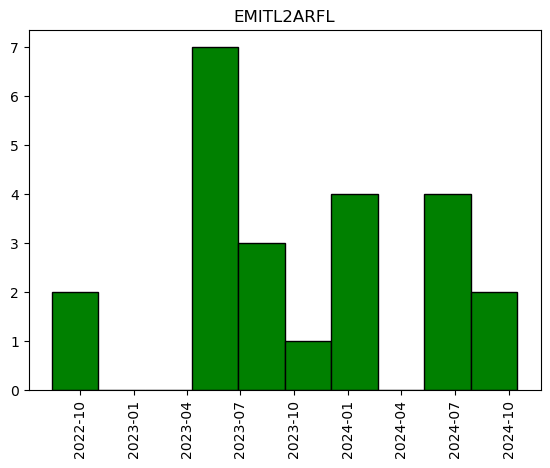

In [34]:
emit_gdf.hist(column='datetime_obj', by='shortname', bins=10, color='green', edgecolor='black', linewidth=1, sharey=True);


## 4. Visualizing Intersecting Coverage

Now that we have geodataframes containing some co-located data, we can visualize them on a map using `folium`. It's often difficult to visualize a large time-series of scenes, so we've included an example in Appendix A1 on how to filter to a single day.

In [36]:
# Plot Using Folium
# Create Figure and Select Background Tiles
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add Site Bounding Box
folium.GeoJson(site_bbox,
                name='bounding_box',).add_to(map1)

# Add roi geodataframe
site_polygon.explore("flightbxID",
                      popup=True,
                      categorical=True,
                      cmap='Set3',
                      style_kwds=dict(opacity=0.7, fillOpacity=0.4),
                      name="SOAP ROI",
                      m=map1)

# Plot STAC EMITL2ARFL Results - note we must drop the datetime_obj columns for this to work
emit_gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)

map1.fit_bounds(bounds=convert_bounds(emit_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

C:\Users\riede\AppData\Local\Temp\ipykernel_7948\2462934989.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map1.fit_bounds(bounds=convert_bounds(emit_gdf.unary_union.bounds))


### 4.2 Previewing EMIT Browse Imagery
The EMIT browse imagery is not orthorectified, so to get an idea what scenes look like, we can plot them in a grid using matplotlib.

> Note: The black space is indicative of onboard cloud masking that occurs before data is downlinked from the ISS.

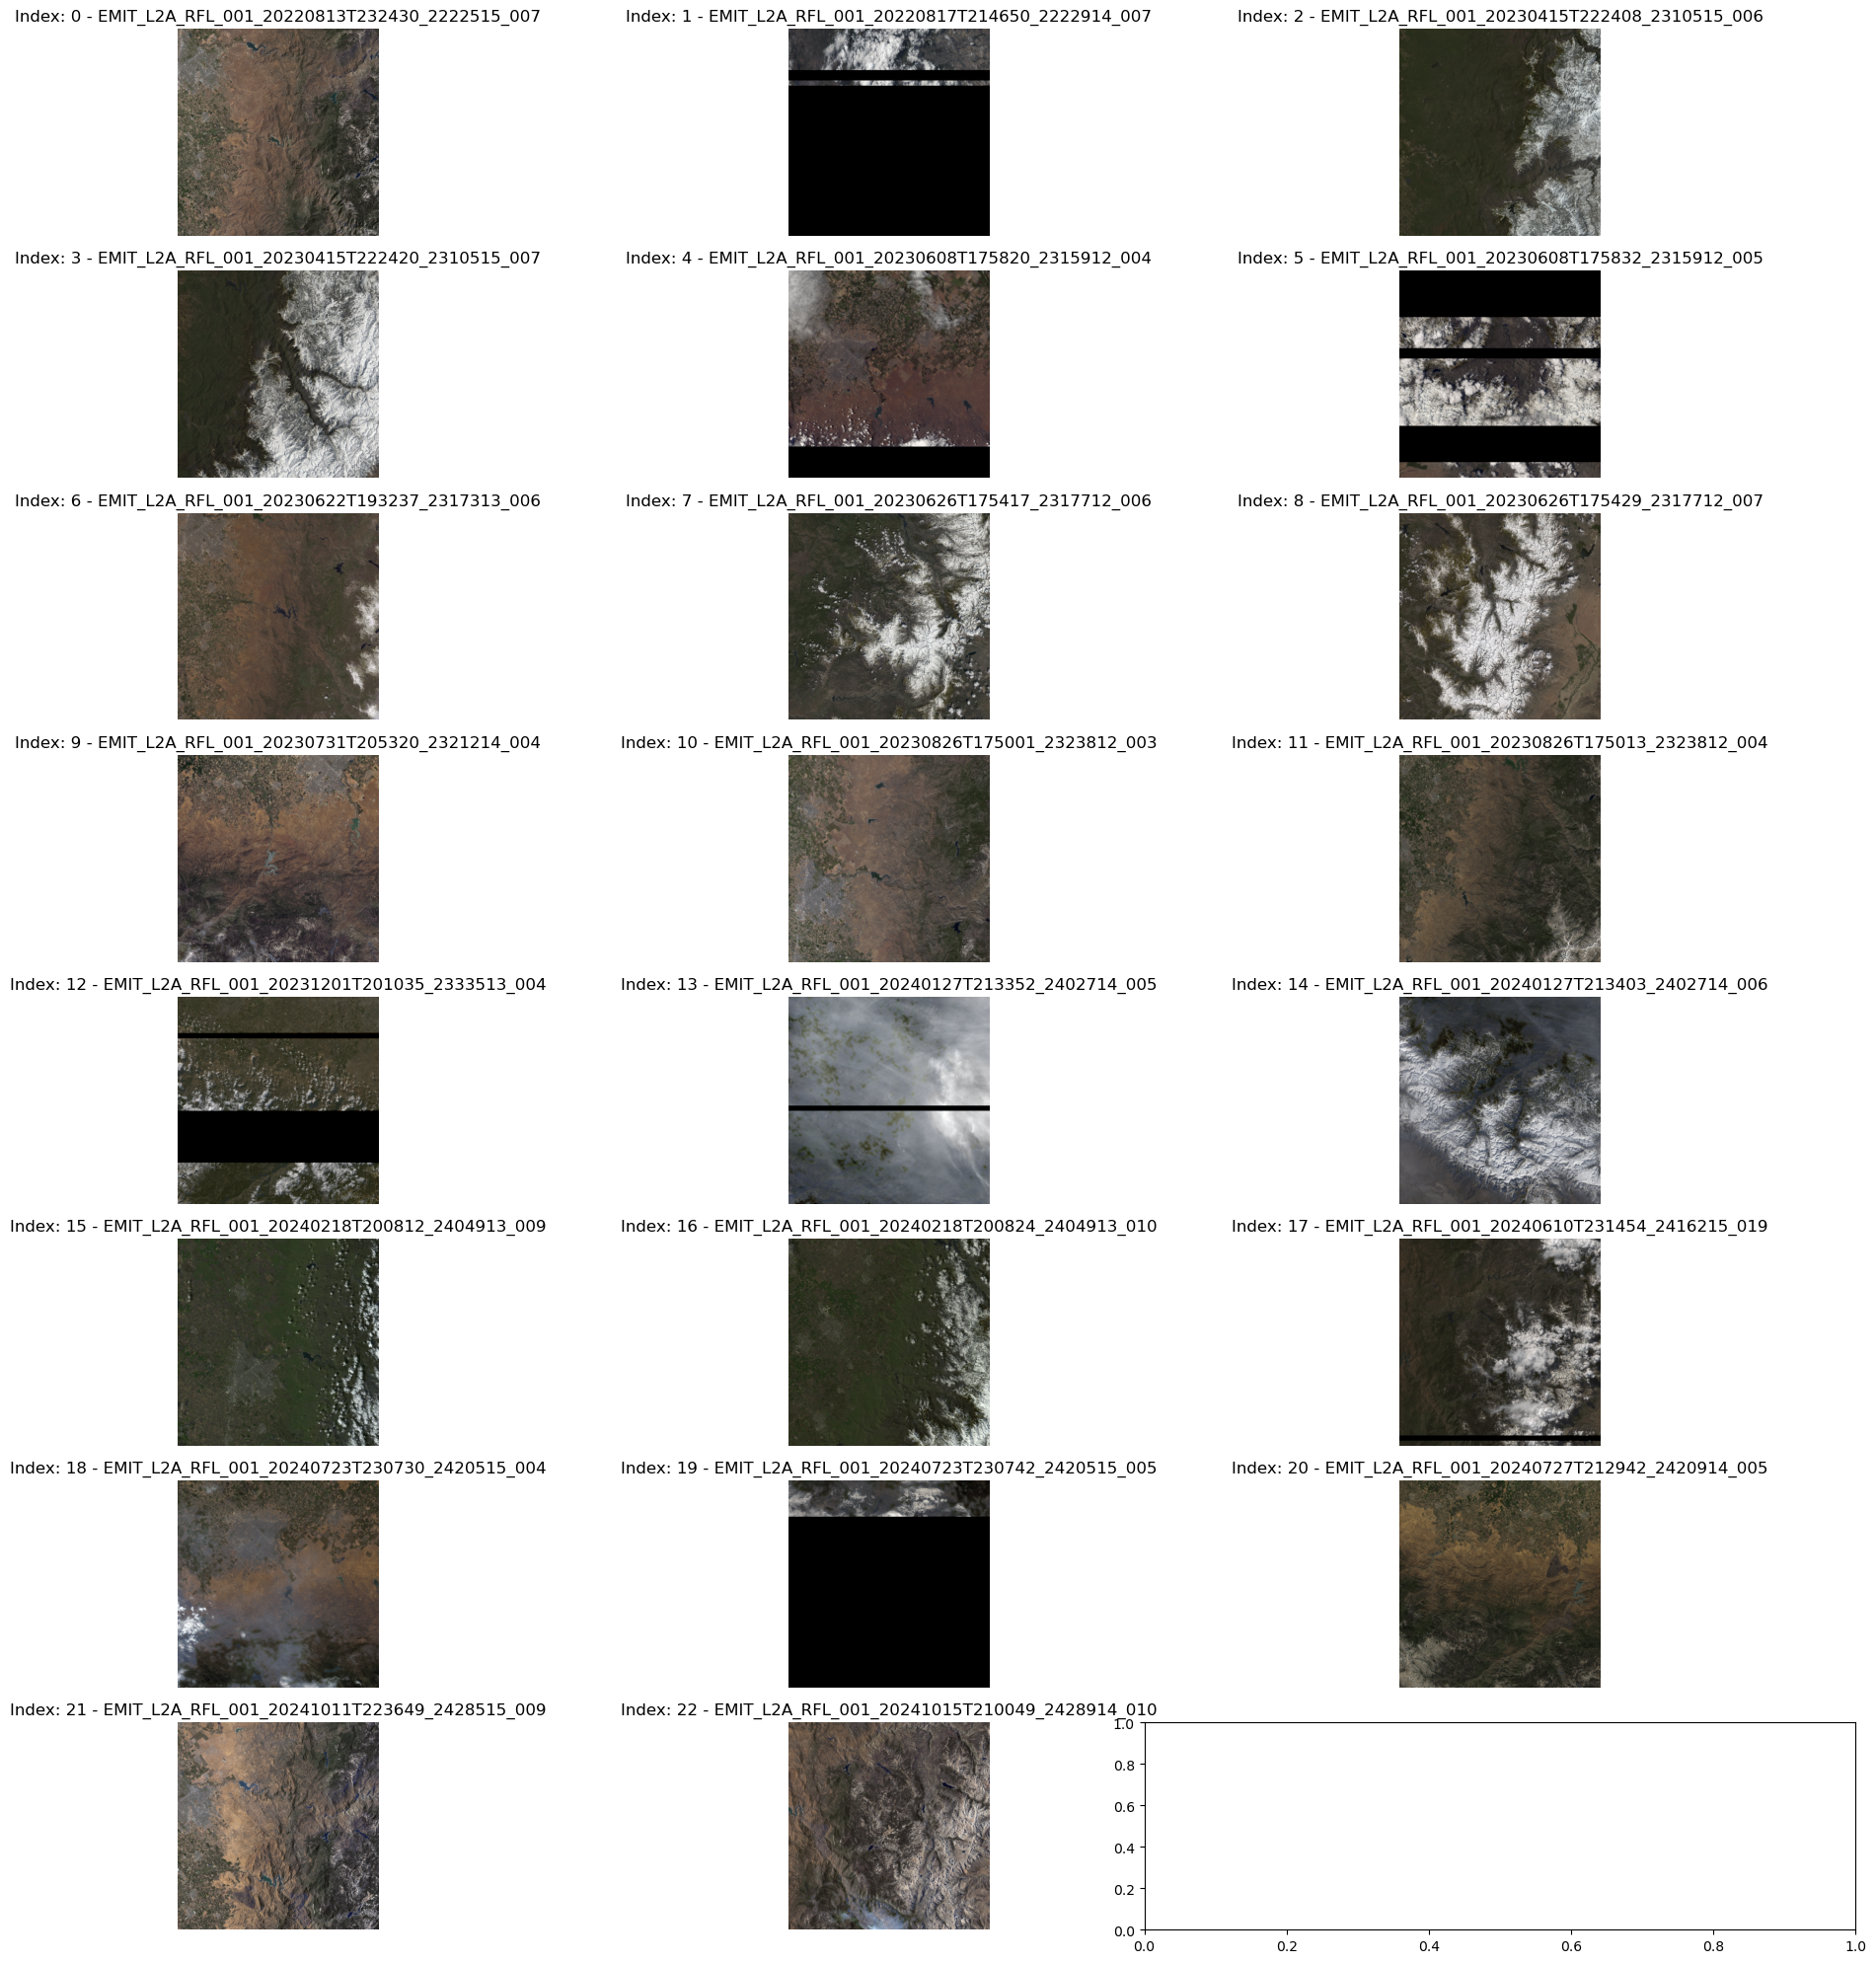

In [37]:
cols = 3
rows = math.ceil(len(emit_gdf)/cols)
fig, ax = plt.subplots(rows, cols, figsize=(20,20))
ax = ax.flatten()

for _n, index in enumerate(emit_gdf.index.to_list()):
    img = io.imread(emit_gdf['browse'][index])
    ax[_n].imshow(img)
    ax[_n].set_title(f"Index: {index} - {emit_gdf['granule'][index]}")
    ax[_n].axis('off')
plt.tight_layout()
plt.show()

### 4.3 Further Filtering

We can see that some of these granules likely won't work because of the large amount of cloud cover, we can use a list of these to filter them out. Make a list of indexes to filter out.

In [38]:
# set a threshold for cloud cover and filter to remove scenes with >30% cloud cover
emit_gdf_clear = emit_gdf[emit_gdf.cloud_cover < 30]
emit_gdf_clear

concept_id                                       granule  \
0   G2597030211-LPCLOUD  EMIT_L2A_RFL_001_20220813T232430_2222515_007   
2   G2658516156-LPCLOUD  EMIT_L2A_RFL_001_20230415T222408_2310515_006   
3   G2658516087-LPCLOUD  EMIT_L2A_RFL_001_20230415T222420_2310515_007   
6   G2736728172-LPCLOUD  EMIT_L2A_RFL_001_20230622T193237_2317313_006   
9   G2743397410-LPCLOUD  EMIT_L2A_RFL_001_20230731T205320_2321214_004   
10  G2759644643-LPCLOUD  EMIT_L2A_RFL_001_20230826T175001_2323812_003   
11  G2759650982-LPCLOUD  EMIT_L2A_RFL_001_20230826T175013_2323812_004   
20  G3177327289-LPCLOUD  EMIT_L2A_RFL_001_20240727T212942_2420914_005   
21  G3265882496-LPCLOUD  EMIT_L2A_RFL_001_20241011T223649_2428515_009   
22  G3279486184-LPCLOUD  EMIT_L2A_RFL_001_20241015T210049_2428914_010   

          start_datetime          end_datetime  cloud_cover day_night  \
0   2022-08-13T23:24:30Z  2022-08-13T23:24:42Z            9       Day   
2   2023-04-15T22:24:08Z  2023-04-15T22:24:20Z           23       Day   
3   2023-04-15T22:24:20Z  2023-04-15T22:24:32Z           27       Day   
6   2023-06-22T19:32:37Z  2023-06-22T19:32:49Z            8       Day   
9   2023-07-31T20:53:20Z  2023-07-31T20:53:32Z            5       Day   
10  2023-08-26T17:50:01Z  2023-08-26T17:50:13Z            8       Day   
11  2023-08-26T17:50:13Z  2023-08-26T17:50:25Z            7       Day   
20  2024-07-27T21:29:42Z  2024-07-27T21:29:53Z            3       Day   
21  2024-10-11T22:36:49Z  2024-10-11T22:37:01Z            9       Day   
22  2024-10-15T21:00:49Z  2024-10-15T21:01:01Z           16       Day   

                                             geometry  \
0   POLYGON ((-119.46864 37.47018, -119.92542 36.8...   
2   POLYGON ((-119.72453 37.86227, -120.18778 37.2...   
3   POLYGON ((-119.0284 37.37526, -119.49146 36.72...   
6   POLYGON ((-119.43843 37.42319, -119.89761 36.7...   
9   POLYGON ((-119.12272 37.51724, -119.97849 36.9...   
10  POLYGON ((-119.83958 37.67923, -120.30956 37.0...   
11  POLYGON ((-119.13836 37.19188, -119.61771 36.5...   
20  POLYGON ((-118.87672 37.27332, -119.72562 36.6...   
21  POLYGON ((-119.5981 37.60208, -120.05849 36.95...   
22  POLYGON ((-119.14209 37.70631, -119.59476 37.0...   

                                               browse   shortname  \
0   https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
2   https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
3   https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
6   https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
9   https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
10  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
11  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
20  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
21  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
22  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   

                datetime_obj  
0  2022-08-13 23:24:30+00:00  
2  2023-04-15 22:24:08+00:00  
3  2023-04-15 22:24:20+00:00  
6  2023-06-22 19:32:37+00:00  
9  2023-07-31 20:53:20+00:00  
10 2023-08-26 17:50:01+00:00  
11 2023-08-26 17:50:13+00:00  
20 2024-07-27 21:29:42+00:00  
21 2024-10-11 22:36:49+00:00  
22 2024-10-15 21:00:49+00:00

Filter out the bad granules.

We can see that there are some scenes with low (<30%) cloud cover. 

Let's take a look at the July 27, 2024 EMIT dataset (Index 15):

- **20**: `EMIT_L2A_RFL_001_20240727T212942_2420914_005`

We can plot this scene as follows:

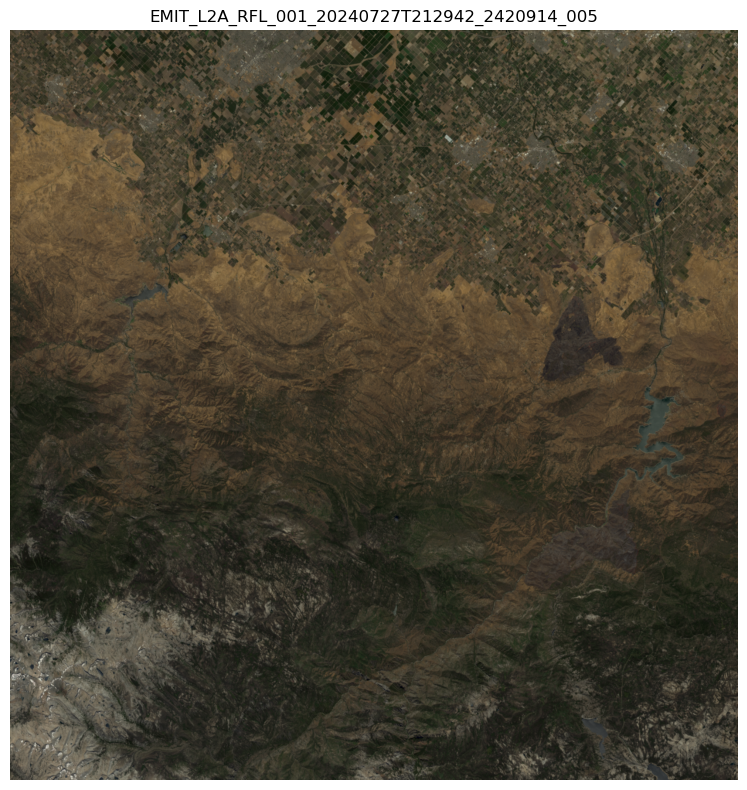

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
img = io.imread(emit_gdf['browse'][20])
ax.imshow(img)
ax.set_title(f"{emit_gdf['granule'][20]}")
ax.axis('off')
plt.tight_layout()
plt.show()

**We can now go back to our `folium` plot above and  re-run the cell to update it based on our filtering.**

In [40]:
emit_gdf_july_2023 = emit_gdf[emit_gdf['granule'] == 'EMIT_L2A_RFL_001_20230731T205320_2321214_004']

In [41]:
# Plot Using Folium
# Create Figure and Select Background Tiles
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add the Site Bounding Box
folium.GeoJson(site_bbox,
                name='bounding_box',
                ).add_to(map1)

# Add roi geodataframe
site_polygon.explore("flightbxID",
                      popup=True,
                      categorical=True,
                      cmap='Set3',
                      style_kwds=dict(opacity=0.7, fillOpacity=0.4),
                      name="SOAP ROI",
                      m=map1)

# Plot STAC EMITL2ARFL Results - note we must drop the datetime_obj columns for this to work
emit_gdf_july_2023.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)

map1.fit_bounds(bounds=convert_bounds(emit_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

C:\Users\riede\AppData\Local\Temp\ipykernel_7948\2696422318.py:37: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map1.fit_bounds(bounds=convert_bounds(emit_gdf.unary_union.bounds))


### 5.1 Define EMIT Collections of Interest - L2B
We need to specify which products we want to search for. The best way to do this is using their concept-id. As mentioned above, we will conduct our search using the EMIT L2B Estimated Mineral Identification and Band Depth and Uncertainty 60 m (EMITL2BMIN). We can do some quick collection queries using `earthaccess` to retrieve the concept-id for each dataset. 

In [42]:
# EMIT Collection Query
emit_collection_query = earthaccess.collection_query().keyword('EMIT L2B')
emit_collection_query.fields(['ShortName','EntryTitle','Version']).get()

[{
   "meta": {
     "concept-id": "C2748088093-LPCLOUD",
     "granule-count": 1574,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "EMITL2BCH4PLM",
     "EntryTitle": "EMIT L2B Estimated Methane Plume Complexes 60 m V001",
     "Version": "001"
   }
 },
 {
   "meta": {
     "concept-id": "C2408034484-LPCLOUD",
     "granule-count": 148249,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "EMITL2BMIN",
     "EntryTitle": "EMIT L2B Estimated Mineral Identification and Band Depth and Uncertainty 60 m V001",
     "Version": "001"
   }
 },
 {
   "meta": {
     "concept-id": "C3242680113-LPCLOUD",
     "granule-count": 4572,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "EMITL2BCH4ENH",
     "EntryTitle": "EMIT L2B Methane Enhancement Data 60 m V002",
     "Version": "002"
   }
 },
 {
   "meta": {
     "concept-id": "C2748097305-LPCLOUD",
     "granule-count": 2165,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "EM

In [45]:
# Data Collections for our search
emit_l2b_concept_id = ['C2408034484-LPCLOUD']

In [46]:
# Define Date Range
date_range = ('2022-01-01','2024-11-01')

In [47]:
# submit a new query for the L2B data
emit_l2b_query_results = earthaccess.search_data(
    concept_id=emit_l2b_concept_id,
    polygon=site_roi,
    temporal=date_range,
    count=500)

In [48]:
# check query
emit_l2b_query_results

[Collection: {'ShortName': 'EMITL2BMIN', 'Version': '001'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -119.46864318847656, 'Latitude': 37.470184326171875}, {'Longitude': -119.9254150390625, 'Latitude': 36.824989318847656}, {'Longitude': -119.16255187988281, 'Latitude': 36.284912109375}, {'Longitude': -118.70578002929688, 'Latitude': 36.93010711669922}, {'Longitude': -119.46864318847656, 'Latitude': 37.470184326171875}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-08-13T23:24:30Z', 'EndingDateTime': '2022-08-13T23:24:42Z'}}
 Size(MB): 88.35936832427979
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20220813T232430_2222515_007/EMIT_L2B_MIN_001_20220813T232430_2222515_007.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20220813T232430_2222515_007/EMIT_L2B_MINUNCERT_001_20220813T232430_2

In [49]:
# Create Dataframe of Results Metadata
emit_l2b_results_df = pd.json_normalize(emit_l2b_query_results)
# Create shapely polygons for result
geometries = [get_shapely_object(emit_l2b_query_results[index]) for index in emit_l2b_results_df.index.to_list()]
# Convert to GeoDataframe
emit_l2b_gdf = gpd.GeoDataFrame(emit_l2b_results_df, geometry=geometries, crs="EPSG:4326")
# Remove emit_results_df, no longer needed
del emit_l2b_results_df
# Add browse imagery links
emit_l2b_gdf['browse'] = [get_png(granule) for granule in emit_l2b_query_results]
emit_l2b_gdf['shortname'] = [result['umm']['CollectionReference']['ShortName'] for result in emit_l2b_query_results]
# Preview GeoDataframe
print(f'{emit_l2b_gdf.shape[0]} granules total')

23 granules total


In [50]:
emit_l2b_gdf.head()

size meta.concept-type      meta.concept-id  meta.revision-id  \
0  88.359368           granule  G2702145790-LPCLOUD                 3   
1  77.169458           granule  G2702474255-LPCLOUD                 3   
2  79.344578           granule  G2732438243-LPCLOUD                 2   
3  77.506337           granule  G2732438241-LPCLOUD                 2   
4  84.222391           granule  G2738551352-LPCLOUD                 2   

                                 meta.native-id meta.collection-concept-id  \
0  EMIT_L2B_MIN_001_20220813T232430_2222515_007        C2408034484-LPCLOUD   
1  EMIT_L2B_MIN_001_20220817T214650_2222914_007        C2408034484-LPCLOUD   
2  EMIT_L2B_MIN_001_20230415T222408_2310515_006        C2408034484-LPCLOUD   
3  EMIT_L2B_MIN_001_20230415T222420_2310515_007        C2408034484-LPCLOUD   
4  EMIT_L2B_MIN_001_20230608T175820_2315912_004        C2408034484-LPCLOUD   

  meta.provider-id                        meta.format  \
0          LPCLOUD  application/vnd.nasa.cmr.umm+json   
1          LPCLOUD  application/vnd.nasa.cmr.umm+json   
2          LPCLOUD  application/vnd.nasa.cmr.umm+json   
3          LPCLOUD  application/vnd.nasa.cmr.umm+json   
4          LPCLOUD  application/vnd.nasa.cmr.umm+json   

         meta.revision-date  \
0  2024-10-28T16:36:47.273Z   
1  2024-10-28T17:10:43.228Z   
2  2024-10-29T14:05:43.157Z   
3  2024-10-29T14:05:43.466Z   
4  2024-10-29T23:58:46.745Z   

  umm.TemporalExtent.RangeDateTime.BeginningDateTime  ...  \
0                               2022-08-13T23:24:30Z  ...   
1                               2022-08-17T21:46:50Z  ...   
2                               2023-04-15T22:24:08Z  ...   
3                               2023-04-15T22:24:20Z  ...   
4                               2023-06-08T17:58:20Z  ...   

  umm.DataGranule.DayNightFlag  \
0                          Day   
1                          Day   
2                          Day   
3                          Day   
4                          Day   

   umm.DataGranule.ArchiveAndDistributionInformation  \
0  [{'Name': 'EMIT_L2B_MIN_001_20220813T232430_22...   
1  [{'Name': 'EMIT_L2B_MIN_001_20220817T214650_22...   
2  [{'Name': 'EMIT_L2B_MIN_001_20230415T222408_23...   
3  [{'Name': 'EMIT_L2B_MIN_001_20230415T222420_23...   
4  [{'Name': 'EMIT_L2B_MIN_001_20230608T175820_23...   

  umm.DataGranule.ProductionDateTime  \
0               2023-07-02T02:49:55Z   
1               2023-07-08T10:05:02Z   
2               2023-07-14T08:36:05Z   
3               2023-07-14T08:36:04Z   
4               2023-07-25T21:20:25Z   

                                       umm.Platforms  \
0  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
1  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
2  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
3  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
4  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   

                       umm.MetadataSpecification.URL  \
0  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
1  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
2  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
3  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
4  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   

  umm.MetadataSpecification.Name umm.MetadataSpecification.Version  \
0                          UMM-G                             1.6.6   
1                          UMM-G                             1.6.6   
2                          UMM-G                             1.6.6   
3                          UMM-G                             1.6.6   
4                          UMM-G                             1.6.6   

                                            geometry  \
0  POLYGON ((-119.46864 37.47018, -119.92542 36.8...   
1  POLYGON ((-119.68089 38.26041, -120.12322 37.6...   
2  POLYGON ((-119.72453 37.86227, -120.18778 37.2...   
3  POLYGON ((-119.0284 37.37526, -119.49146 36.72...   
4  POLYGON ((-119.63505 37.57834, -120.4885 3

In [51]:
# Create a list of columns to keep
keep_cols = ['meta.concept-id','meta.native-id', 'umm.TemporalExtent.RangeDateTime.BeginningDateTime','umm.TemporalExtent.RangeDateTime.EndingDateTime','umm.CloudCover','umm.DataGranule.DayNightFlag','geometry','browse', 'shortname']
# Remove unneeded columns
emit_l2b_gdf = emit_l2b_gdf[emit_l2b_gdf.columns.intersection(keep_cols)]
emit_l2b_gdf.head()

meta.concept-id                                meta.native-id  \
0  G2702145790-LPCLOUD  EMIT_L2B_MIN_001_20220813T232430_2222515_007   
1  G2702474255-LPCLOUD  EMIT_L2B_MIN_001_20220817T214650_2222914_007   
2  G2732438243-LPCLOUD  EMIT_L2B_MIN_001_20230415T222408_2310515_006   
3  G2732438241-LPCLOUD  EMIT_L2B_MIN_001_20230415T222420_2310515_007   
4  G2738551352-LPCLOUD  EMIT_L2B_MIN_001_20230608T175820_2315912_004   

  umm.TemporalExtent.RangeDateTime.BeginningDateTime  \
0                               2022-08-13T23:24:30Z   
1                               2022-08-17T21:46:50Z   
2                               2023-04-15T22:24:08Z   
3                               2023-04-15T22:24:20Z   
4                               2023-06-08T17:58:20Z   

  umm.TemporalExtent.RangeDateTime.EndingDateTime  umm.CloudCover  \
0                            2022-08-13T23:24:42Z               9   
1                            2022-08-17T21:47:02Z              93   
2                            2023-04-15T22:24:20Z              23   
3                            2023-04-15T22:24:32Z              27   
4                            2023-06-08T17:58:32Z              47   

  umm.DataGranule.DayNightFlag  \
0                          Day   
1                          Day   
2                          Day   
3                          Day   
4                          Day   

                                            geometry  \
0  POLYGON ((-119.46864 37.47018, -119.92542 36.8...   
1  POLYGON ((-119.68089 38.26041, -120.12322 37.6...   
2  POLYGON ((-119.72453 37.86227, -120.18778 37.2...   
3  POLYGON ((-119.0284 37.37526, -119.49146 36.72...   
4  POLYGON ((-119.63505 37.57834, -120.4885 36.97...   

                                              browse   shortname  
0  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN  
1  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN  
2  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN  
3  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN  
4  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN

In [55]:
# Rename some Columns
emit_l2b_gdf.rename(columns = {'meta.concept-id':'concept_id','meta.native-id':'granule',
                           'umm.TemporalExtent.RangeDateTime.BeginningDateTime':'start_datetime',
                           'umm.TemporalExtent.RangeDateTime.EndingDateTime':'end_datetime',
                           'umm.CloudCover':'cloud_cover',
                           'umm.DataGranule.DayNightFlag':'day_night'}, inplace=True)
emit_l2b_gdf.head()

concept_id                                       granule  \
0  G2702145790-LPCLOUD  EMIT_L2B_MIN_001_20220813T232430_2222515_007   
1  G2702474255-LPCLOUD  EMIT_L2B_MIN_001_20220817T214650_2222914_007   
2  G2732438243-LPCLOUD  EMIT_L2B_MIN_001_20230415T222408_2310515_006   
3  G2732438241-LPCLOUD  EMIT_L2B_MIN_001_20230415T222420_2310515_007   
4  G2738551352-LPCLOUD  EMIT_L2B_MIN_001_20230608T175820_2315912_004   

         start_datetime          end_datetime  cloud_cover day_night  \
0  2022-08-13T23:24:30Z  2022-08-13T23:24:42Z            9       Day   
1  2022-08-17T21:46:50Z  2022-08-17T21:47:02Z           93       Day   
2  2023-04-15T22:24:08Z  2023-04-15T22:24:20Z           23       Day   
3  2023-04-15T22:24:20Z  2023-04-15T22:24:32Z           27       Day   
4  2023-06-08T17:58:20Z  2023-06-08T17:58:32Z           47       Day   

                                            geometry  \
0  POLYGON ((-119.46864 37.47018, -119.92542 36.8...   
1  POLYGON ((-119.68089 38.26041, -120.12322 37.6...   
2  POLYGON ((-119.72453 37.86227, -120.18778 37.2...   
3  POLYGON ((-119.0284 37.37526, -119.49146 36.72...   
4  POLYGON ((-119.63505 37.57834, -120.4885 36.97...   

                                              browse   shortname  
0  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN  
1  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN  
2  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN  
3  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN  
4  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN

Don't need to filter emit_l2b_gdf by "Day" in "day_night" column because all the granules are "Day".

In [56]:
emit_l2b_gdf['datetime_obj'] = pd.to_datetime(emit_l2b_gdf['start_datetime']) # 2i2c
emit_l2b_gdf['datetime_obj'] = pd.to_datetime(emit_l2b_gdf['start_datetime'], format='ISO8601') # Local ENV

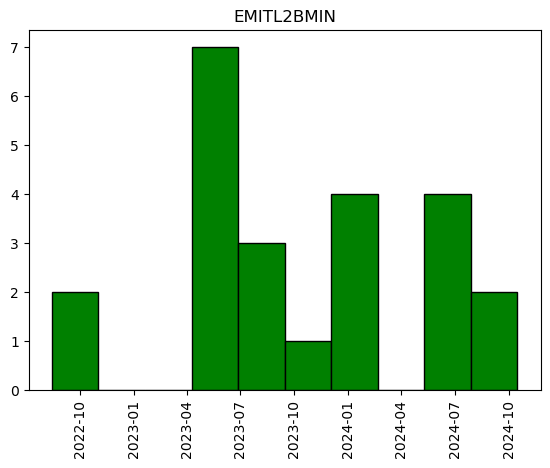

In [57]:
# visualize quantity of results:
emit_l2b_gdf.hist(column='datetime_obj', by='shortname', bins=10, color='green', edgecolor='black', linewidth=1, sharey=True);

Visualize intersecting coverage:

In [59]:
# Plot Using Folium
# Create Figure and Select Background Tiles
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add Site Bounding Box
folium.GeoJson(site_bbox,
                name='bounding_box',).add_to(map1)

# Add roi geodataframe
site_polygon.explore("flightbxID",
                      popup=True,
                      categorical=True,
                      cmap='Set3',
                      style_kwds=dict(opacity=0.7, fillOpacity=0.4),
                      name="SOAP ROI",
                      m=map1)

# Plot EMITL2BMIN Results - note we must drop the datetime_obj columns for this to work
emit_l2b_gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)

# write title
title_html = '''<h3 align="center" style="font-size:16px"><b>Intersecting Data: EMIT L2B Granules & NEON SOAP Flight Boxes</b></h3>'''

map1.fit_bounds(bounds=convert_bounds(emit_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())

# add title to map
map1.get_root().html.add_child(folium.Element(title_html))
display(fig)

C:\Users\riede\AppData\Local\Temp\ipykernel_7948\3510764657.py:39: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map1.fit_bounds(bounds=convert_bounds(emit_gdf.unary_union.bounds))


Preview EMIT L2B MIN granules:

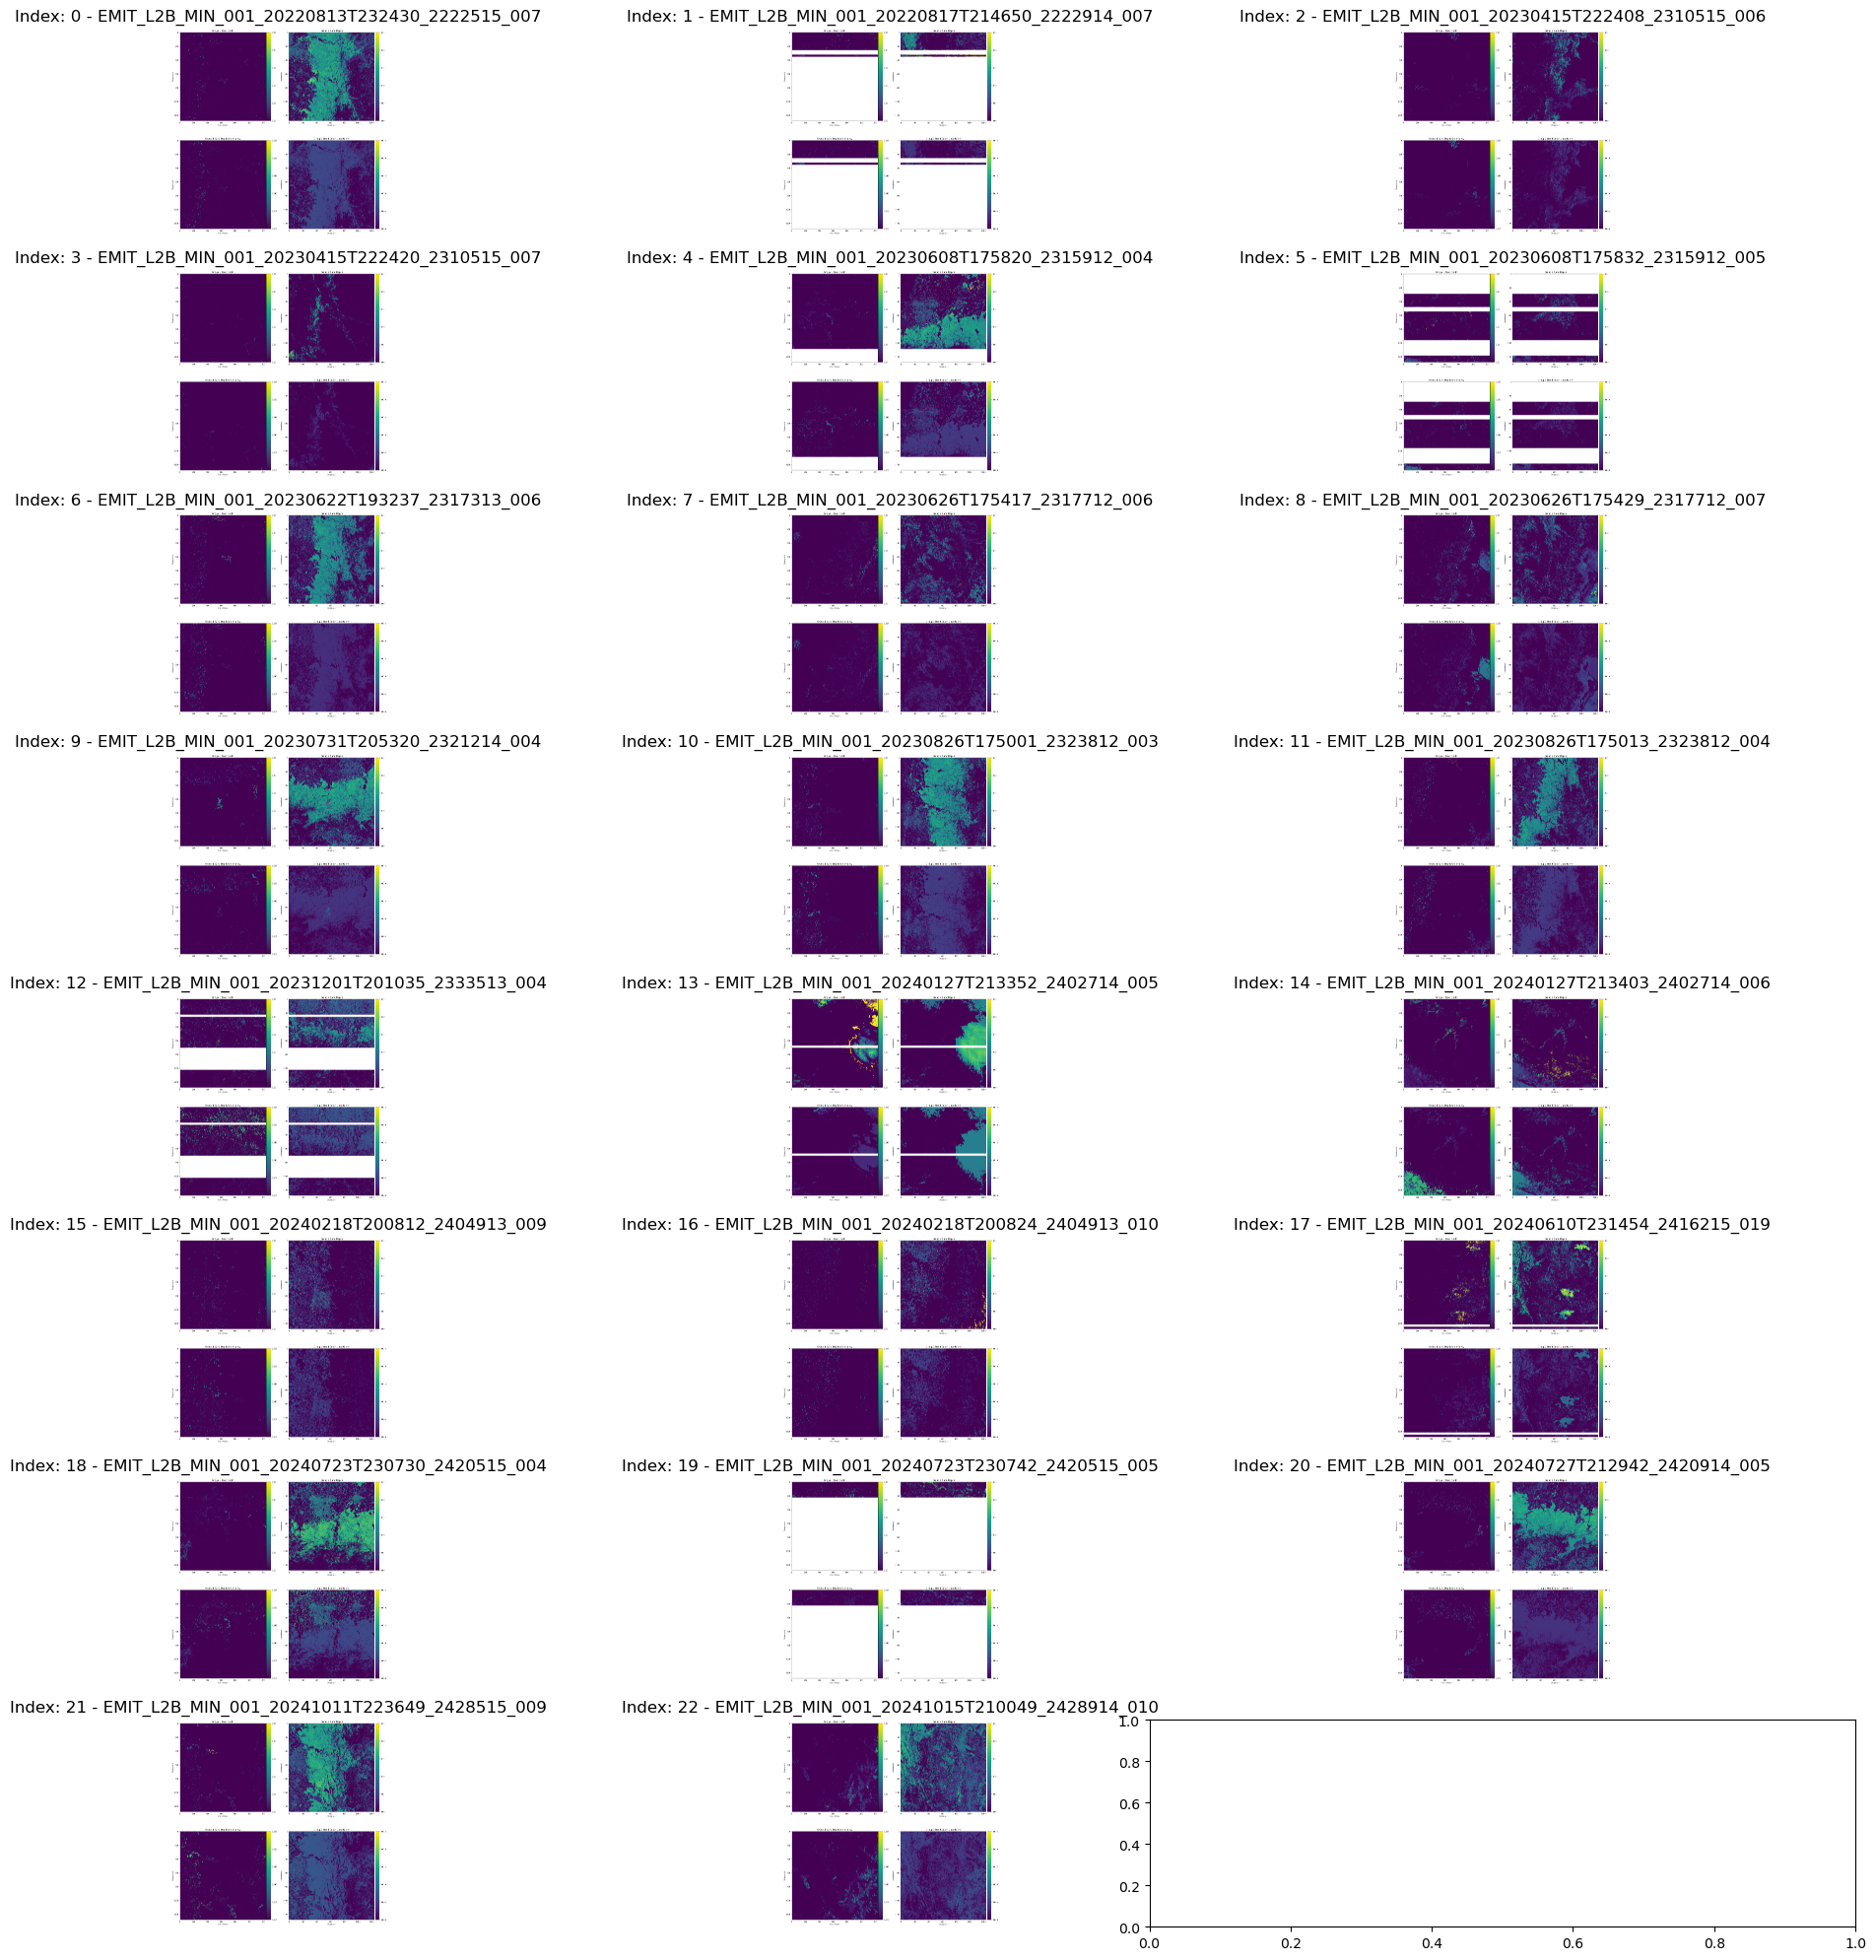

In [60]:
# set up figure cols/rows
cols = 3
rows = math.ceil(len(emit_l2b_gdf)/cols)
fig, ax = plt.subplots(rows, cols, figsize=(20,20))
ax = ax.flatten()

for _n, index in enumerate(emit_l2b_gdf.index.to_list()):
    img = io.imread(emit_l2b_gdf['browse'][index])
    ax[_n].imshow(img)
    ax[_n].set_title(f"Index: {index} - {emit_l2b_gdf['granule'][index]}")
    ax[_n].axis('off')
plt.tight_layout()
plt.show()

In [63]:
# set a threshold for cloud cover and filter to remove scenes with >30% cloud cover
emit_l2b_gdf_clear = emit_l2b_gdf[emit_l2b_gdf.cloud_cover < 30]
emit_l2b_gdf_clear

concept_id                                       granule  \
0   G2702145790-LPCLOUD  EMIT_L2B_MIN_001_20220813T232430_2222515_007   
2   G2732438243-LPCLOUD  EMIT_L2B_MIN_001_20230415T222408_2310515_006   
3   G2732438241-LPCLOUD  EMIT_L2B_MIN_001_20230415T222420_2310515_007   
6   G2736729403-LPCLOUD  EMIT_L2B_MIN_001_20230622T193237_2317313_006   
9   G2743536819-LPCLOUD  EMIT_L2B_MIN_001_20230731T205320_2321214_004   
10  G2759650320-LPCLOUD  EMIT_L2B_MIN_001_20230826T175001_2323812_003   
11  G2759651123-LPCLOUD  EMIT_L2B_MIN_001_20230826T175013_2323812_004   
20  G3177330318-LPCLOUD  EMIT_L2B_MIN_001_20240727T212942_2420914_005   
21  G3265867461-LPCLOUD  EMIT_L2B_MIN_001_20241011T223649_2428515_009   
22  G3279453390-LPCLOUD  EMIT_L2B_MIN_001_20241015T210049_2428914_010   

          start_datetime          end_datetime  cloud_cover day_night  \
0   2022-08-13T23:24:30Z  2022-08-13T23:24:42Z            9       Day   
2   2023-04-15T22:24:08Z  2023-04-15T22:24:20Z           23       Day   
3   2023-04-15T22:24:20Z  2023-04-15T22:24:32Z           27       Day   
6   2023-06-22T19:32:37Z  2023-06-22T19:32:49Z            8       Day   
9   2023-07-31T20:53:20Z  2023-07-31T20:53:32Z            5       Day   
10  2023-08-26T17:50:01Z  2023-08-26T17:50:13Z            8       Day   
11  2023-08-26T17:50:13Z  2023-08-26T17:50:25Z            7       Day   
20  2024-07-27T21:29:42Z  2024-07-27T21:29:53Z            3       Day   
21  2024-10-11T22:36:49Z  2024-10-11T22:37:01Z            9       Day   
22  2024-10-15T21:00:49Z  2024-10-15T21:01:01Z           16       Day   

                                             geometry  \
0   POLYGON ((-119.46864 37.47018, -119.92542 36.8...   
2   POLYGON ((-119.72453 37.86227, -120.18778 37.2...   
3   POLYGON ((-119.0284 37.37526, -119.49146 36.72...   
6   POLYGON ((-119.43843 37.42319, -119.89761 36.7...   
9   POLYGON ((-119.12272 37.51724, -119.97849 36.9...   
10  POLYGON ((-119.83958 37.67923, -120.30956 37.0...   
11  POLYGON ((-119.13836 37.19188, -119.61771 36.5...   
20  POLYGON ((-118.87672 37.27332, -119.72562 36.6...   
21  POLYGON ((-119.5981 37.60208, -120.05849 36.95...   
22  POLYGON ((-119.14209 37.70631, -119.59476 37.0...   

                                               browse   shortname  \
0   https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN   
2   https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN   
3   https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN   
6   https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN   
9   https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN   
10  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN   
11  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN   
20  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN   
21  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN   
22  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2BMIN   

                datetime_obj  
0  2022-08-13 23:24:30+00:00  
2  2023-04-15 22:24:08+00:00  
3  2023-04-15 22:24:20+00:00  
6  2023-06-22 19:32:37+00:00  
9  2023-07-31 20:53:20+00:00  
10 2023-08-26 17:50:01+00:00  
11 2023-08-26 17:50:13+00:00  
20 2024-07-27 21:29:42+00:00  
21 2024-10-11 22:36:49+00:00  
22 2024-10-15 21:00:49+00:00

We can see that there are some scenes with low (<30%) cloud cover. 

Let's take a look at the October 15, 2024 EMIT dataset (Index 22):

- **22**: `EMIT_L2B_MIN_001_20241015T210049_2428914_010`

We can plot this scene as follows:

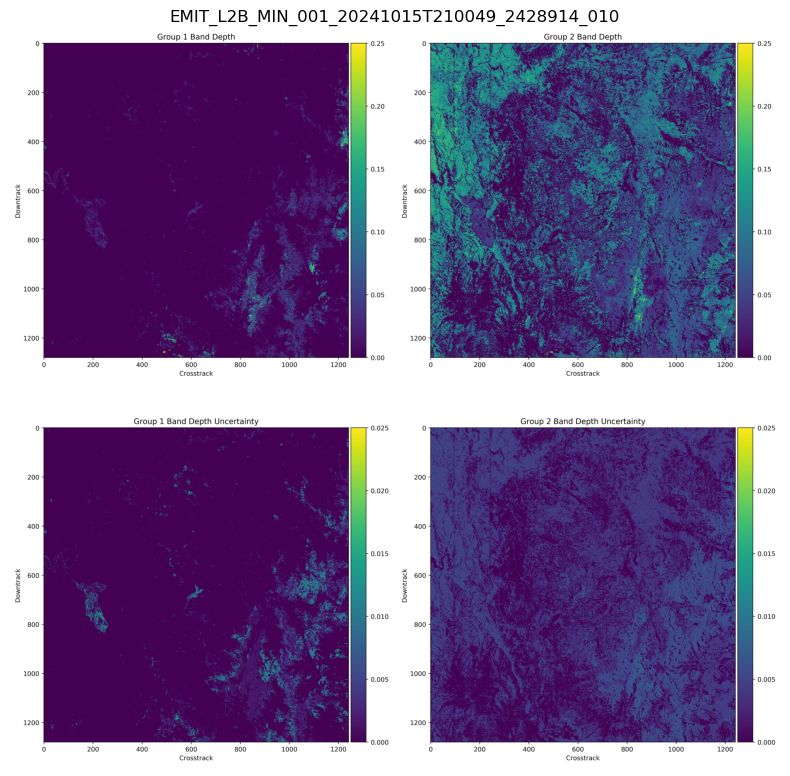

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
img = io.imread(emit_l2b_gdf['browse'][22])
ax.imshow(img)
ax.set_title(f"{emit_l2b_gdf['granule'][22]}")
ax.axis('off')
plt.tight_layout()
plt.show()

Plot the October 15, 2024 granule with the SOAP flight boxes:

In [65]:
emit_l2b_oct_2024 = emit_l2b_gdf[emit_l2b_gdf['granule'] == 'EMIT_L2B_MIN_001_20241015T210049_2428914_010']

In [66]:
# Plot Using Folium
# Create Figure and Select Background Tiles
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add the Site Bounding Box
folium.GeoJson(site_bbox,
                name='bounding_box',
                ).add_to(map1)

# Add roi geodataframe
site_polygon.explore("flightbxID",
                      popup=True,
                      categorical=True,
                      cmap='Set3',
                      style_kwds=dict(opacity=0.7, fillOpacity=0.4),
                      name="SOAP ROI",
                      m=map1)

# Plot one EMIT L2B granule - note we must drop the datetime_obj columns for this to work
emit_l2b_oct_2024.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)

# write title
title_html = '''<h3 align="center" style="font-size:16px"><b>EMIT_L2B_MIN_001_20241015T210049_2428914_010 & NEON SOAP Flight Boxes</b></h3>'''

map1.fit_bounds(bounds=convert_bounds(emit_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())

# add title to map
map1.get_root().html.add_child(folium.Element(title_html))

display(fig)

C:\Users\riede\AppData\Local\Temp\ipykernel_7948\2161946837.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map1.fit_bounds(bounds=convert_bounds(emit_gdf.unary_union.bounds))


## 6. Generating a list of URLs and downloading data

Creating a list of results URLs will include all of these assets, so if we only want a subset we need an additional filter to keep the specific assets we want.

If you look back, you can see we kept the same indexing throughout the notebook. This enables us to simply subset the `earthaccess` results object to retrieve the results we want. 

Create a list of index values to keep.

# *Cells below commented out because the data that is downloaded is too big to push from the local version of my repo to github. We are working on a way to fix this.*

In [ ]:
# keep_granules = [1]

Filter the results list.

In [ ]:
# filtered_results = [result for i, result in enumerate(emit_query_results) if i in keep_granules]

Now we can download all of the associated assets, or retrieve the URLS and further filter them to specifically what we want. 

First, log into Earthdata using the `login` function from the `earthaccess` library. The `persist=True` argument will create a local `.netrc` file if it doesn't exist, or add your login info to an existing `.netrc` file. If no Earthdata Login credentials are found in the `.netrc` you'll be prompted for them. As mentioned in section 1.2, this step is not necessary to conduct searches, but is needed to download or stream data.

In [ ]:
# earthaccess.login()

Now we can download all assets using the following cell.

In [ ]:
# # Download All Assets for Granules in Filtered Results
# earthaccess.download(filtered_results, '../data/SOAP/emit_refl')

Or we can create a list of URLs and use that to further refine which files we download.

In [ ]:
# Retrieve URLS for Assets
results_urls = [granule.data_links() for granule in filtered_results]

In [ ]:
# results_urls

We can see this is a nested list. Granules often have several assets associated with them, for example, `EMIT_L2A` has several assets:

- RFL
- RFLUNCERT
- MASK
  
The results list we just generated contains URLs to all of these assets nested by granule. We can further filter our results list using string matching to remove unwanted assets.

Create a list of strings and enumerate through our results_url list to filter out unwanted assets and remove the nesting.

In [ ]:
# filtered_asset_links = []
# # Pick Desired Assets (leave _ on RFL to distinguish from RFLUNC, LST. to distinguish from LST_err)
# desired_assets = ['RFL_','MASK', 'LST.'] # Add more or do individually for reflectance, reflectance uncertainty, or mask
# # Step through each sublist (granule) and filter based on desired assets.
# for n, granule in enumerate(results_urls):
#     for url in granule: 
#         asset_name = url.split('/')[-1]
#         if any(asset in asset_name for asset in desired_assets):
#             filtered_asset_links.append(url)
# filtered_asset_links

We can see that this removed the `REFLUNCERT` data. We can also write this list of files to a text file to have a record of data used, or stream the data using `https` as we access them. For streaming the data, the EMIT files are very large, so operations can take some time.

In [ ]:
# with open('./data/emit_search_results.txt', 'w') as f:
#     for line in filtered_asset_links:
#         f.write(f"{line}\n")

Open the list of required granules.

>Note: You can download all of the files using the cell below and recreate all of the canopy water content files following a workflow similar to the example in notebooks 2 and 3 for all of the necessary scenes. To do this, uncomment the `file_list` object with the `emit_search_results.txt` filepath to download all of the results rather than just what is required.

In [ ]:
# # Open Text File and Read Lines
# #file_list = './data/required_granules.txt'
# file_list = './data/emit_search_results.txt'
# with open(file_list) as f:
#     urls = [line.rstrip('\n') for line in f]

Download the required granules.

In [ ]:
# # Create a directory to store the downloaded emit data
# os.makedirs('./data/emit_refl', exist_ok=True)
# # Get requests https session using Earthdata Login Info
# fs = earthaccess.get_requests_https_session()
# # Retrieve granule asset ID from URL (to maintain existing naming convention)
# for url in urls:
#     granule_asset_id = url.split('/')[-1]
#     # Define Local Filepath
#     fp = f'./data/emit_refl/{granule_asset_id}'
#     # Download the Granule Asset if it doesn't exist
#     if not os.path.isfile(fp):
#         with fs.get(url,stream=True) as src:
#             with open(fp,'wb') as dst:
#                 for chunk in src.iter_content(chunk_size=64*1024*1024):
#                     dst.write(chunk)

Congratulations, now you have downloaded co-located hyperspectral reflectance data from NEON airborne collections and the EMIT instrument on the ISS.

## Contact Info:  

**Land Processes Distributed Active Archive Center (LP DAAC)**<sup>1</sup>

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Website: <https://lpdaac.usgs.gov/>  

<sup>1</sup>Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I. 

**National Ecological Observatory Network (NEON)**<sup>2</sup>

Website: <https://www.neonscience.org/>   
Contact: <https://www.neonscience.org/about/contact-us>   
Date last modified: 08-27-2024 

<sup>2</sup>NEON is a project sponsored by the National Science Foundation and operated by Battelle.